In [1]:
from deep_bf.data_handler import DataLoader, rf2iq

dl = DataLoader("../../../rf_data")
pw = dl.get_defined_pwdata("contrast_speckle_expe_dataset_rf", "RF")

nz = 1024
nx = 512
decimation = 1

fs = pw.fs
fc = pw.fc
rf = pw.data

#iq = rf2iq(rf, fs, fc)
#print(iq.shape)

In [2]:
rf = rf[:, :, None, :]
rf.shape

(75, 128, 1, 3328)

In [ ]:
from deep_bf.beamformers import compute_d_rx, compute_d_tx, compute_meshgrid, compute_samples, GridSampleDAS

bf = GridSampleDAS(nz, nx).cuda()
Z, X = compute_meshgrid(pw, nz, nx)
d_rx = compute_d_rx(pw, Z, X)

import torch
import numpy as np

#angles = [0, pw.n_angles//2, pw.n_angles-1]
#angles = [pw.n_angles//2]
angles = np.arange(pw.n_angles)

das = torch.zeros((1, 1, nz, nx), device='cuda', dtype=torch.float16)
for angle_idx in angles:
    d_tx, t0 = compute_d_tx(pw, Z, X, angle_idx)
    samples = compute_samples(pw, d_tx, d_rx, t0, decimation)

    rf_tensor = torch.from_numpy(rf[angle_idx, ...]).half().unsqueeze(0).cuda()
    samples_tensor = torch.from_numpy(samples).half().unsqueeze(0).cuda()

    with torch.no_grad():
        das += bf(rf_tensor, samples_tensor)

das = das / len(angles)

In [3]:
from deep_bf.beamformers import GridSampleDAS

bf = GridSampleDAS(nz, nx).cuda()

In [4]:
from deep_bf.beamformers import compute_d_rx, compute_d_tx, compute_meshgrid, compute_samples

Z, X = compute_meshgrid(pw, nz, nx)
d_rx = compute_d_rx(pw, Z, X)

In [6]:
import torch
import numpy as np

#angles = [0, pw.n_angles//2, pw.n_angles-1]
#angles = [pw.n_angles//2]
angles = np.arange(pw.n_angles)

das = torch.zeros((1, 1, nz, nx), device='cuda', dtype=torch.float16)
for angle_idx in angles:
    d_tx, t0 = compute_d_tx(pw, Z, X, angle_idx)
    samples = compute_samples(pw, d_tx, d_rx, t0, decimation)

    rf_tensor = torch.from_numpy(rf[angle_idx, ...]).half().unsqueeze(0).cuda()
    samples_tensor = torch.from_numpy(samples).half().unsqueeze(0).cuda()

    with torch.no_grad():
        das += bf(rf_tensor, samples_tensor)

das = das / len(angles)

In [42]:
import torch
import torch.nn as nn
import torch.fft

class BModeFromRF(nn.Module):
    def __init__(self, dynamic_range=60, gain_db=0):
        super().__init__()
        self.dr = dynamic_range
        self.gain = gain_db
        self.min_signal = 1e-8 

    def get_envelope(self, rf_signal):
        """
        Calcula la envolvente usando Hilbert vía FFT.
        Espera input: [Batch, Channel, Z, X]
        Asume que el eje Z (dim=2) es el eje temporal/profundidad.
        """
        # Casting a float32 es vital para la precisión de la FFT
        original_dtype = rf_signal.dtype
        rf = rf_signal.float() 
        
        N = rf.shape[2] # Dimensión Z
        
        # 1. FFT
        H_fft = torch.fft.fft(rf, dim=2)
        
        # 2. Filtro Analítico (Mantiene DC, Duplica Positivas, Elimina Negativas)
        h = torch.zeros(N, device=rf.device, dtype=H_fft.dtype)
        h[0] = 1.0
        h[1 : (N + 1) // 2] = 2.0
        if N % 2 == 0:
            h[N // 2] = 1.0
            
        h = h.view(1, 1, -1, 1) # Broadcasting para [B, C, Z, X]
        
        # 3. IFFT y Magnitud
        analytic_signal = torch.fft.ifft(H_fft * h, dim=2)
        envelope = torch.abs(analytic_signal)
        
        return envelope.to(original_dtype)

    def forward(self, rf_sum):
        # 1. Envolvente
        env = self.get_envelope(rf_sum)
        
        # 2. Log Compression
        env = torch.clamp(env, min=self.min_signal)
        env_db = 20 * torch.log10(env)
        
        # 3. Normalización por el máximo global del batch/imagen
        # Aplanamos para buscar el max
        batch, ch, h, w = env_db.shape
        flat = env_db.reshape(batch, ch, -1)
        ref_val = flat.max(dim=-1, keepdim=True).values.view(batch, ch, 1, 1)
        
        # Auto-gain + Gain manual
        env_norm = env_db - ref_val.detach() + self.gain
        
        # 4. Mapeo al Rango Dinámico [0, 1]
        image = (env_norm + self.dr) / self.dr
        return torch.clamp(image, 0, 1)

bmode_engine = BModeFromRF(dynamic_range=60, gain_db=0).cuda()

In [43]:
with torch.no_grad():
    b_mode = bmode_engine(das)

b_mode = b_mode.squeeze().cpu().numpy()

In [33]:
import numpy as np
from scipy.signal import hilbert

env = hilbert(das.cpu().numpy(), axis=0)
b_mode = 20 * np.log10(np.abs(env) + 1e-10)
b_mode -= np.amax(b_mode)
b_mode= b_mode.squeeze()

4. Visualizando...


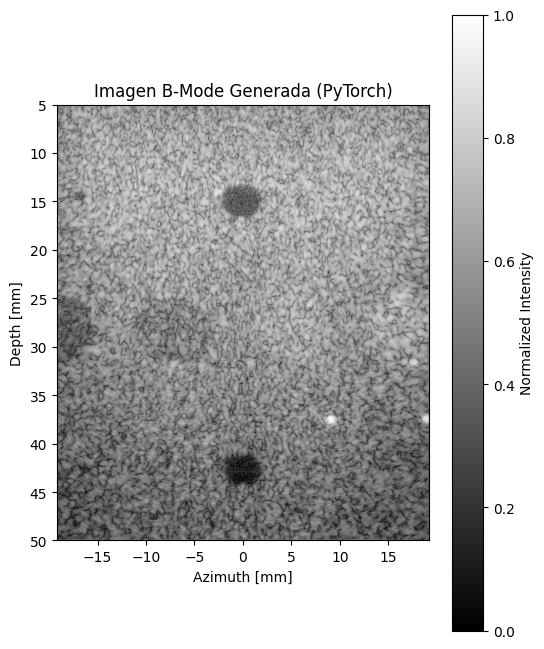

In [44]:
import matplotlib.pyplot as plt

zlims = np.array([Z[0, 0], Z[-1, 0]]) * 1e3
xlims = np.array([X[0, 0], X[0, -1]]) * 1e3

# --- E. VISUALIZACIÓN ---
print("4. Visualizando...")
#img_np = b_mode.squeeze().cpu().numpy()

plt.figure(figsize=(6, 8))
plt.imshow(b_mode, cmap='gray', extent=(xlims[0], xlims[-1], zlims[-1], zlims[0]))
plt.title("Imagen B-Mode Generada (PyTorch)")
plt.xlabel("Azimuth [mm]")
plt.ylabel("Depth [mm]")
plt.colorbar(label="Normalized Intensity")
plt.show()